In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
df = pd.read_csv('/gdrive/My Drive/Colab Notebooks/DubaiTemp.csv')
df.head()

,Unnamed: 0,date,temperature_2m
0,0,2010-01-01 00:00:00+00:00,13.928500
1,1,2010-01-01 01:00:00+00:00,13.278501
2,2,2010-01-01 02:00:00+00:00,12.728500
3,3,2010-01-01 03:00:00+00:00,12.328500
4,4,2010-01-01 04:00:00+00:00,12.828500


### 📈 Temperature Data – RMSE Evaluation

In [4]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,LSTM, Input, Dropout, RepeatVector, TimeDistributed
from keras.models import Model
from keras import optimizers
import random
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from tensorflow import keras

In [5]:
print('Start Date ', df['date'].min())
print('End Date ', df['date'].max())
print('Total Observation', df.shape[0])

Start Date  2010-01-01 00:00:00+00:00
End Date  2022-12-31 23:00:00+00:00
Total Observation 113952


<Axes: xlabel='date', ylabel='temperature_2m'>

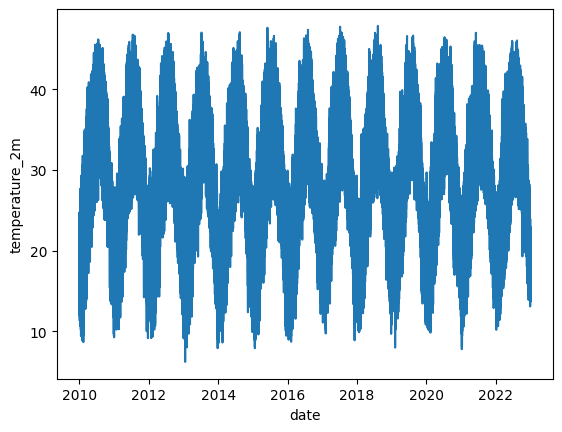

In [6]:
df = df[['date','temperature_2m']]
df['date'] = pd.to_datetime(df['date'])
sns.lineplot(x='date',y='temperature_2m',data=df)

<Axes: xlabel='date', ylabel='temperature_2m'>

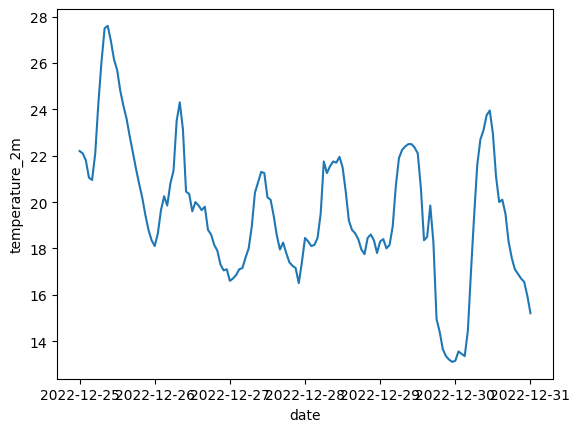

In [7]:
df_sample = df[(df['date'] >= '2022-12-25') & (df['date'] <= '2022-12-31')]
sns.lineplot(x='date',y='temperature_2m',data=df_sample)

In [8]:
def create_dataset(X, sequence_length =24,cols = ['date', 'temperature_2m']):
    Xs, idx = [], []
    for i in range(len(X) - sequence_length +1):
        v = X[cols[1]].iloc[i:(i + sequence_length)].values
        v = v.reshape(sequence_length, 1)
        Xs.append(v)
        idx.append(list(X[cols[0]].iloc[i:(i + sequence_length)]))
    return np.array(Xs), list(idx)

def perturb_outliers(df, perturb_cols = 0.001,
                     perturb_val = 0):
    perturb_cols = df.sample(int(df.shape[0]*perturb_cols)).index
    df.loc[perturb_cols,df.columns != 'date'] = perturb_val


    return df

def impute(df,key,sequence_length, model = None, scaler = None):
    keys = {
    1: {"col": 'temperature_2m', 'impute_mode': 'simple', 'impute_method' : 'mean'},
    2: {"col": 'temperature_2m', 'impute_mode': 'simple', 'impute_method' : 'median'},
    3: {"col": 'temperature_2m_transformed', 'impute_mode': 'LSTM_AE', 'impute_method' : 'mean'},
    4: {"col": 'temperature_2m_transformed', 'impute_mode': 'LSTM_AE', 'impute_method' : 'median'}
}

    df = df[['date', keys[key]['col']]]
    cols = list(df.columns)
    array, idx = create_dataset(df, sequence_length, cols)

    indices_with_zero = [i for i in range(array.shape[0]) if 0 in array[i]]
    zero_elements_idx = [idx[i][j] for i in range(array.shape[0]) for j in range(array.shape[1]) if array[i, j] == 0]

    if key == 1:
        impute_val = [[np.mean([x for x in array[i] if x != 0])]*np.sum(array[i] == 0) for i in indices_with_zero]
        impute_val = [item for sublist in impute_val for item in sublist]
        label = keys[key]['col'] + '_' + keys[key]['impute_mode'] + '_' + keys[key]['impute_method']
        result_df = pd.DataFrame({'date':zero_elements_idx, label : impute_val})
        result_df = result_df.groupby('date')[label].mean().reset_index()

    elif key == 2:
        impute_val = [[np.median([x for x in array[i] if x != 0])]*np.sum(array[i] == 0) for i in indices_with_zero]
        impute_val = [item for sublist in impute_val for item in sublist]
        label = keys[key]['col'] + '_' + keys[key]['impute_mode'] + '_' + keys[key]['impute_method']
        result_df = pd.DataFrame({'date':zero_elements_idx, label : impute_val})
        result_df = result_df.groupby('date')[label].median().reset_index()

    elif key == 3:
        prediction = model.predict(array)
        prediction = np.array([scaler. inverse_transform(prediction[i]) for i in range(prediction.shape[0])] )
        prediction = [prediction[i,j].item() for i in range(array.shape[0]) for j in range(array.shape[1]) if array[i, j] == 0]
        label = keys[key]['col'] + '_' + keys[key]['impute_mode'] + '_' + keys[key]['impute_method']
        result_df = pd.DataFrame({'date':zero_elements_idx, label : prediction})
        result_df = result_df.groupby('date')[label].mean().reset_index()

    elif key == 4:
        prediction = model.predict(array)
        prediction = np.array([ scaler. inverse_transform(prediction[i]) for i in range(prediction.shape[0])] )
        prediction = [prediction[i,j].item() for i in range(array.shape[0]) for j in range(array.shape[1]) if array[i, j] == 0]
        label = keys[key]['col'] + '_' + keys[key]['impute_mode'] + '_' + keys[key]['impute_method']
        result_df = pd.DataFrame({'date':zero_elements_idx, label : prediction})
        result_df = result_df.groupby('date')[label].median().reset_index()

    return result_df


In [9]:
date_cutoff = '2022-07-31'
train_df = df[df['date'] < date_cutoff].reset_index(drop = True )
val_df = df[df['date'] >=  date_cutoff].reset_index(drop = True )


scaler = StandardScaler()
scaler = scaler.fit(train_df[['temperature_2m']])
train_df['temperature_2m'] = scaler.transform(train_df[['temperature_2m']])
#val_df['temperature_2m'] = scaler.transform(val_df[['temperature_2m']])

# Creating Training data
sequence_length = 24
train_df, train_idx = create_dataset(train_df,sequence_length,['date', 'temperature_2m'])

### 🧠 Temperature Data – LSTM Autoencoder Architecture

In [10]:
model = Sequential()
model.add(LSTM(units=64,input_shape=(train_df.shape[1], train_df.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(n=train_df.shape[1]))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(units=train_df.shape[2])))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVecto  (None, 24, 64)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 24, 64)            0         
                                                                 
 time_distributed (TimeDist  (None, 24, 1)             65        
 ributed)                                               

### 🚀 Temperature Data – Model Training

In [12]:
model_state = 1 # 0 if needs to be built

if model_state == 1:
  model = keras.models.load_model('/gdrive/My Drive/Colab Notebooks/model.h5')
else:
    history = model.fit(train_df, train_df,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)
    model_label = 'model_v1.h5'
    model_label = '/gdrive/My Drive/Colab Notebooks/' + model_label
    model.save(model_label)

### 📊 Temperature Data – Plot of True vs Imputed Values

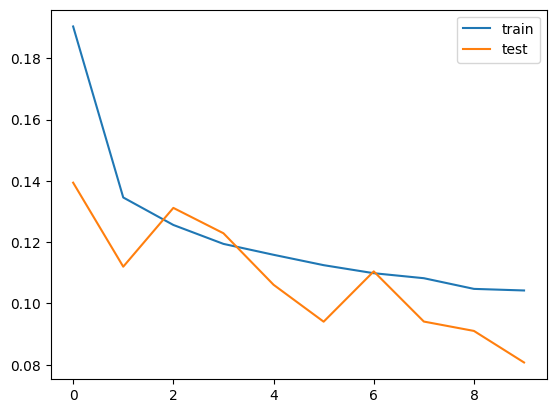

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### 📊 Temperature Data – Plot of True vs Imputed Values

3445/3445 [==============================] - 36s 10ms/step


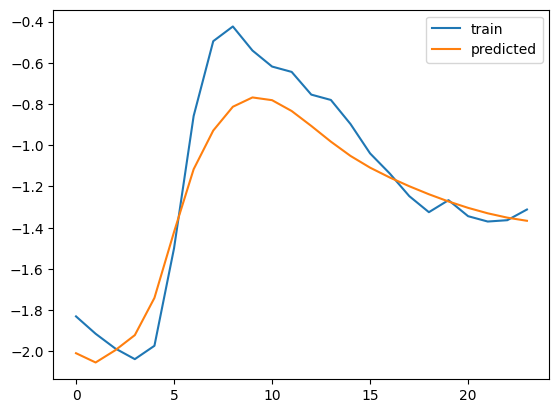

In [13]:
predictions = model.predict(train_df)
plt.plot(train_df[0], label='train')
plt.plot(predictions[0], label='predicted')
plt.legend();

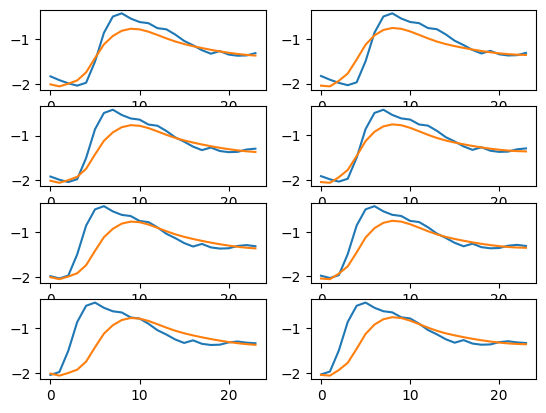

In [14]:
num_plots = 8 # select a even number
num_plots = int(num_plots/2) #fix the num of cols to 2
fig, axs = plt.subplots(num_plots, 2)
num_plots = np.array(random.sample(range(predictions.shape[0]),int(num_plots*2))).reshape(num_plots,2)

for i in range(num_plots.shape[0]):
    for j in range(num_plots.shape[1]):
      sample_x = train_df[i]
      sample_y = predictions[j]
      axs[i, j].plot(sample_x, label='train')
      axs[i, j].plot(sample_y, label='predicted')


In [15]:
val_df_perturb = val_df.copy()
val_df_perturb['temperature_2m_transformed'] = scaler.transform(val_df_perturb[['temperature_2m']])
val_df_perturb = perturb_outliers(val_df_perturb,perturb_cols = 0.01)

In [18]:
#creating imputations on missing values
result_df = val_df[val_df['date'].isin(val_df_perturb[val_df_perturb['temperature_2m'] == 0].date)]
result_df = result_df.merge(impute(val_df_perturb,key = 1,sequence_length = 24), on = 'date')
result_df = result_df.merge(impute(val_df_perturb,key = 2,sequence_length = 24), on = 'date')
result_df = result_df.merge(impute(val_df_perturb,key = 3,sequence_length = 24,model = model, scaler = scaler), on = 'date')
result_df = result_df.merge(impute(val_df_perturb,key = 4,sequence_length = 24,model = model, scaler = scaler), on = 'date')


115/115 [==============================] - 2s 13ms/step


In [19]:
result_df

,date,temperature_2m,temperature_2m_simple_mean,temperature_2m_simple_median,temperature_2m_transformed_LSTM_AE_mean,temperature_2m_transformed_LSTM_AE_median
0,2022-07-31 07:00:00+00:00,39.604500,36.159118,35.304497,37.315521,37.236679
1,2022-08-17 06:00:00+00:00,38.354500,33.614554,32.704500,36.009628,36.173656
2,2022-08-19 17:00:00+00:00,33.554497,34.310477,33.754498,32.039970,32.063362
3,2022-08-24 23:00:00+00:00,29.604500,36.785918,36.879498,28.901390,28.855194
4,2022-08-25 02:00:00+00:00,28.054500,36.856480,36.879498,28.101155,28.034436
5,2022-08-29 13:00:00+00:00,38.004498,32.774246,32.654497,35.960327,36.108377
6,2022-09-01 02:00:00+00:00,26.154501,32.827688,32.704500,26.750547,26.771749
7,2022-09-02 04:00:00+00:00,28.354500,32.253775,31.829500,29.437383,29.279263
8,2022-09-06 11:00:00+00:00,38.054497,33.277869,32.404500,37.598265,37.724379
9,2022-09-12 07:00:00+00:00,36.554497,31.554850,31.004500,35.710015,35.814751


### 📊 Temperature Data – Plot of True vs Imputed Values

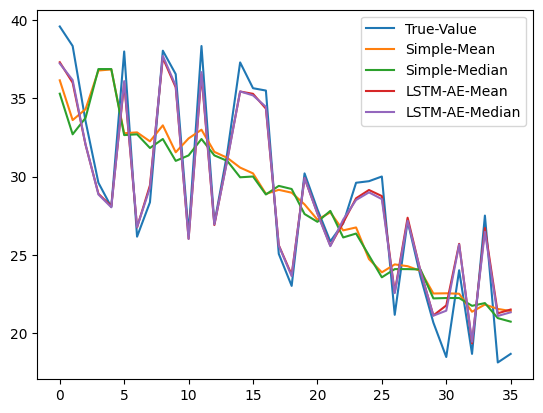

In [22]:
plt.plot(result_df['temperature_2m'], label='True-Value')
plt.plot(result_df['temperature_2m_simple_mean'], label='Simple-Mean')
plt.plot(result_df['temperature_2m_simple_median'], label='Simple-Median')
plt.plot(result_df['temperature_2m_transformed_LSTM_AE_mean'], label='LSTM-AE-Mean')
plt.plot(result_df['temperature_2m_transformed_LSTM_AE_median'], label='LSTM-AE-Median')
plt.legend();

### 📈 Temperature Data – RMSE Evaluation

In [21]:
print('simple mean imputation RMSE:')
print(np.sqrt(mean_squared_error(result_df.temperature_2m, result_df.temperature_2m_simple_mean)))
print('simple median imputation RMSE:')
print(np.sqrt(mean_squared_error(result_df.temperature_2m, result_df.temperature_2m_simple_median)))
print('LSTM AE mean imputation RMSE:')
print(np.sqrt(mean_squared_error(result_df.temperature_2m, result_df.temperature_2m_transformed_LSTM_AE_mean)))
print('LSTM AE median imputation RMSE:')
print(np.sqrt(mean_squared_error(result_df.temperature_2m, result_df.temperature_2m_transformed_LSTM_AE_median)))

simple mean imputation RMSE:
4.519990109343575
simple median imputation RMSE:
4.6325168054502806
LSTM AE mean imputation RMSE:
1.3735409339788658
LSTM AE median imputation RMSE:
1.319539200600888
